# 基于LDA主题模型和情感词典的Twitter推文主题提取及情感分析

## 工作环境：(jupyter notebook)


python 3.7.5

pandas 1.0.1 (处理表格数据)

wordcloud 1.8.1 (词云)

stylecloud 0.5.1 (词云)

nltk 3.5 (内含各种停用词，以及词干提取，词形还原和分词的方法)

gensim 3.8.3 (内含LDA模型)

pyLDAvis 3.2.2 (LDA模型可视化工具)

numpy 1.17.4 (数学工具)

matplotlib 3.1.1 (数据可视化绘图工具)

seaborn 0.11.0

Pillow 7.1.2

tqdm 4.46.0

xlrd 1.2.0



## 概念说明
 
 
#### 什么是LDA？

> LDA（隐含狄利克雷分布）**将文档集中的每篇文档的主题以概率分布的形式给出**

> LDA是一种文档主题生成模型，包含词、主题和文档三层结构。我们认为一篇文章的每个词都是通过以一定概率选择了某个主题，并从这个主题中以一定概率选择某个词语。LDA可以用来识别大规模文档集或语料库中潜藏的主题信息，其采用了词袋（bag of words）的方法，这种方法将每一篇文档视为一个词频向量，从而将文本信息转化为易于建模的数字信息



#### 什么是TF-IDF？

> TF: 词频(term frequency) （对于某个文本，单词在某个文本中出现越多次越重要）

> IDF: 逆文档频率(inverse document frequency) （单词在语料库（所有文本）中出现越少次越重要）

> TF-IDF是一种衡量某一篇文档中某个词对该篇文档重要程度的计算方法。通过TF-IDF公式，我们可以计算出这个词对于表现这篇文档主题而言贡献如何。TFIDF的主要思想是：如果某个词或短语在一篇文章中出现的频率TF高，并且在其他文章中很少出现，则认为此词或者短语具有很好的类别区分能力，适合用来分类或提取关键词。




#### 什么是情感词典法？

> 我们在对文本进行分析时，将一篇文本划分为不同的部分并给予不同的权重，再以词汇为基本颗粒进行分数计算；以自己收集或者业界内比较全面的词典作为根据，对文本的所有词语组进行分数的一一对应计算。最终文本的情感得分越高，表示文本所表达的情感越正向；反之则情感越负向





## 流程
1. 数据获取:

使用python爬虫爬取twitter数据,时间线(2020.3.12-2021.1.12)

2. 数据清洗:

    ① 清除存在推文或发布时间缺失的数据条目
    
    ② 将数据按照发布时间前后顺序排序
    
    ③ 数据分布初步分析（随发布时间）

3. 文本预处理:

    ① Twitter_data['content'] 初始数据(完整的推文，完整的句子)
    
    ② Processed_data 去除了标点、@、短词(预处理后的推文，还是句子)
    
    ③ data_words 去除了nltk停用词词典中的停用词、自定义的禁用词列表（如搜索关键词）(分词后的单词矩阵，每篇推文转化为多个单词)


4. **情感分析:**

    ① 根据TF-IDF算法对推文进行关键词提取，进行词云展示（总体、逐月）
    
        1. 提取全局Top20关键词，生成词云展示
        
        2. 逐月分割全局关键词矩阵
        
        3. 逐月提取Top10关键词，生成词云展示
    
    ② 使用LDA主题模型进行训练，提取主题分布
    
        1. 构建LDA模型，进行训练

        2. 计算模型困惑度(Perplexity)和模型一致性得分(Coherence Score)，其中困惑度越低越好，一致性得分越高越好

        3. 为每篇推文分配对应占主导地位的主题（概率较高的）

        4. 调整主题选取数或训练迭代次数等其他参数，迭代调优
        
    ③ 使用情感词典法对文本进行分析， 计算文本情感得分
    
        1. 情感词词典使用SentiWordNet3.0，否定词词典使用自己收集的否定词集合，程度副词词典基于知网词典扩展
        
        2. 判断每个情感词前是否有否定词或程度副词，将它之前的否定词和程度副词划分为一个组，如果有否定词将情感词的情感权值乘以-1，如果有程度副词就乘以程度副词的程度值，最后所有组的得分加起来,计算出推文最终情感得分。其中大于0的归于正向情感，小于0的归于负向情感
        
        3. 数据统计结果分析
        



## 一些数据处理规则
- 在使用三种词典时，为了简化处理数据的方式，去除了所有非单个词语构成的词和含有标点符号的词如far away、don't这种程度副词。考虑到推文的口语化及随意性，将这些标点去除后合并在一起加入了原词典中，如在否定词词典中去除了don't但添加了dont

- 长度过短的词语逻辑性和严谨性太差，可能无法提供较有效的信息，对短词予以了剔除

- 



##### 优点：
- 相比于使用机器学习和深度学习的方法，使用情感词典计算文本得分，无需经过模型的训练和调参，过程更为直观，也更适合于像twitter推文这种短文本的分析（短文本通常有很多逻辑不完整且不符合语法规则的句子）





##### 局限性：
- 情感词典方面:
1. 程度词典不够全面。去除了多词语构成的程度词组，可能会影响到程度词对情感词的影响。数据直观表现是情感得分跨度较小

2. 

- 数据分布方面:
1. 某些月份的数据较少，可能会影响到关键词和主题提取的效果

2. 




## 一、数据清洗

In [1]:
# 导入相关包
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel


import nltk
from nltk.corpus import stopwords

import re
import string

import seaborn as sns

from pprint import pprint

from wordcloud import WordCloud

from PIL import Image

import pyLDAvis.gensim

import stylecloud

from tqdm import tqdm


## 初始化参数设置
- 全局选取关键词Top N
- 逐月选取关键词Top N
- 主题数选取
- 训练迭代次数

In [2]:
# 全局选取关键词Top N
GLOBAL_TOP_N = 20

# 逐月选取关键词Top N
PER_MONTH_TOP_N = 10

# 主题数选取
NUM_TOPICS = 4

# 训练迭代次数
ITERATIONS = 50

In [3]:
# 指定当前工作路径
# print(os.getcwd())
os.chdir(os.getcwd())

# 从csv文件中读入数据
Twitter_data = pd.read_excel('./twitter_covid.xlsx')

# 初始数据部分展示
Twitter_data.head()

,m_content,g_publish_time,m_content_id
0,@business \n\nAstraZeneca Vaccine Trial Halted...,2020-09-10 07:58:13,1055122099071840257
1,@LynnFynn3 @Trey_VonDinkis @jerrylmassey @WhyP...,2020-03-24 07:48:45,1075075334847033345
2,@RealDoctorMike @TEDx I have heard that The Jo...,2020-09-27 07:56:08,1089902266960756736
3,@Reignlight7 @kuriousmind93 @BGLTHMND @LaLaRue...,2020-05-14 07:47:48,1103693354829864961
4,@TaraAngel22018 @NotTheMacAnon1 @CylantJustice...,2020-03-14 07:46:28,1111007349152583680


In [4]:
# 规范化数据 列名称
Twitter_data.rename(
    columns={'m_content': 'content', 'g_publish_time': 'publish_time', 'm_content_id': 'content_id'},
    inplace=True
)

In [5]:
# 爬取初始数据存在空行，需要进行处理
# 可以看到有11744条非空推文，却有11841条发布日期，所以数据肯定存在部分缺失
Twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11841 entries, 0 to 11840
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       11744 non-null  object
 1   publish_time  11841 non-null  object
 2   content_id    11841 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.6+ KB


In [6]:
# 清除缺失推文或缺失发布时间的数据
Twitter_data.dropna(axis=0, how='any', inplace=True)

In [7]:
# 清除了推文为空的数据项
Twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11744 entries, 0 to 11840
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       11744 non-null  object
 1   publish_time  11744 non-null  object
 2   content_id    11744 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 367.0+ KB


In [8]:
# 将发布时间转换成python中的datetime格式,便于后续操作,并将发布时间统一为 year-month-date 的格式

# PS:不使用pd.to_datetime是因为对于某一条数据，我们只关心其发布的日期，在一天中的具体时间并不关心，
# 而pd.datetime会带上 hour-min-sec ，不利于后续操作
Twitter_data['publish_time'] = Twitter_data['publish_time'].map \
(lambda x: datetime.date((int)(x.split('-')[0]), (int)(x.split('-')[1]), (int)(x.split('-')[2].split(' ')[0])))


In [9]:
# 所有数据按照发布时间排序
Twitter_data = Twitter_data.sort_values(by='publish_time')
Twitter_data.reset_index(inplace=True)
del Twitter_data['index']

In [10]:
# 观察到不在预期时间范围内的数据，进行清除
Twitter_data.head()

,content,publish_time,content_id
0,@michaelwhitney did you see eminems 60 minutes...,2010-10-12,27129102240
1,Scientists Say They Can Recreate Living Dinosa...,2015-06-17,610847280258777089
2,https://t.co/pJKiHYyF38,2020-02-15,1228462979215003648
3,The first Silicon Valley death from COVID-19 w...,2020-03-11,1237460460749766657
4,@LukeGoBlue42 @MrOH1O This is incredibly harmf...,2020-03-12,1237815051332898816


In [11]:
#设定起始、截止日期
start_date = datetime.date(2020, 3, 12)
end_date = datetime.date(2021, 1, 12)


for index, date in enumerate(Twitter_data['publish_time']):
    # 在起始日期前或截止日期后,为不符合要求的数据
    if date.__sub__(start_date).days<0 or date.__sub__(end_date).days>0:
        Twitter_data.drop(index=index, inplace=True)
        
Twitter_data = Twitter_data.reset_index()
del Twitter_data['index']

In [12]:
# 可以观察到数据开始和结束都已经符合预期
Twitter_data.head()

,content,publish_time,content_id
0,@LukeGoBlue42 @MrOH1O This is incredibly harmf...,2020-03-12,1237815051332898816
1,@theraffleboy @Lord_Sugar Doesn’t compare to f...,2020-03-12,1237510363891077120
2,@sheikhofchic Oh I've seen soooo many articles...,2020-03-12,1237559994188324865
3,The rush to create a #vaccine for a #covid_19 ...,2020-03-12,1237883791051350024
4,"@jmood88 Please get your flu vaccine, wash you...",2020-03-12,1237708656923283458


In [13]:
Twitter_data.tail()

,content,publish_time,content_id
11735,Just in - Ottawa paying Deloitte 16 million of...,2021-01-12,1348781022003961856
11736,Maine CDC Dir. says COVID-19 vaccines are ’not...,2021-01-12,1348781091952480256
11737,Indonesia gave Sinovac Biotech's COVID-19 vacc...,2021-01-12,1348781193605443586
11738,Bromleag Care Practice part of BGPA @BromleyGP...,2021-01-12,1348781249977085954
11739,Heads of UNR and WCSD say they'll wait to get ...,2021-01-12,1348781003578478593


### 观察原数据在2020.3.12-2021.1.12的分布情况

In [14]:
def format_month_or_day(month_or_day):
    if int(month_or_day)>0 and int(month_or_day)<10:
        return '0' + str(month_or_day)
    else:
        return month_or_day

In [15]:
# 将publish_time进行拆分便于后续统计
Twitter_data['year'] = Twitter_data['publish_time'].map(lambda x: x.year)
Twitter_data['month'] = Twitter_data['publish_time'].map(lambda x: x.month)
Twitter_data['date'] = Twitter_data['publish_time'].map(lambda x: format_month_or_day(x.day))
Twitter_data['year_month'] = Twitter_data['publish_time'].map(lambda x: str(x.year) + '-' + str(format_month_or_day(x.month)))
Twitter_data['times'] = Twitter_data['publish_time'].map(lambda x: 1)

In [16]:
Twitter_data.head()

,content,publish_time,content_id,year,month,date,year_month,times
0,@LukeGoBlue42 @MrOH1O This is incredibly harmf...,2020-03-12,1237815051332898816,2020,3,12,2020-03,1
1,@theraffleboy @Lord_Sugar Doesn’t compare to f...,2020-03-12,1237510363891077120,2020,3,12,2020-03,1
2,@sheikhofchic Oh I've seen soooo many articles...,2020-03-12,1237559994188324865,2020,3,12,2020-03,1
3,The rush to create a #vaccine for a #covid_19 ...,2020-03-12,1237883791051350024,2020,3,12,2020-03,1
4,"@jmood88 Please get your flu vaccine, wash you...",2020-03-12,1237708656923283458,2020,3,12,2020-03,1


In [17]:
# 对于某一天的数据频次统计如下,times为频次
day_data = Twitter_data.groupby(['publish_time'], as_index=False).agg({'times': 'sum'})

In [18]:
day_data

,publish_time,times
0,2020-03-12,37
1,2020-03-13,40
2,2020-03-14,39
3,2020-03-15,38
4,2020-03-16,41
...,...,...
302,2021-01-08,36
303,2021-01-09,39
304,2021-01-10,41
305,2021-01-11,37


In [19]:
# 对于某个月的数据频次统计如下，times为频次
month_data = Twitter_data.groupby(['year_month', 'year', 'month'], as_index=False).agg({'times': 'sum'})
month_data['day'] = 1
month_data['publish_time'] = pd.to_datetime(month_data[['year', 'month', 'day']]) 

In [20]:
month_data[['year_month', 'times']]

,year_month,times
0,2020-03,777
1,2020-04,1065
2,2020-05,1181
3,2020-06,1153
4,2020-07,1200
5,2020-08,1206
6,2020-09,1167
7,2020-10,1201
8,2020-11,1146
9,2020-12,1188


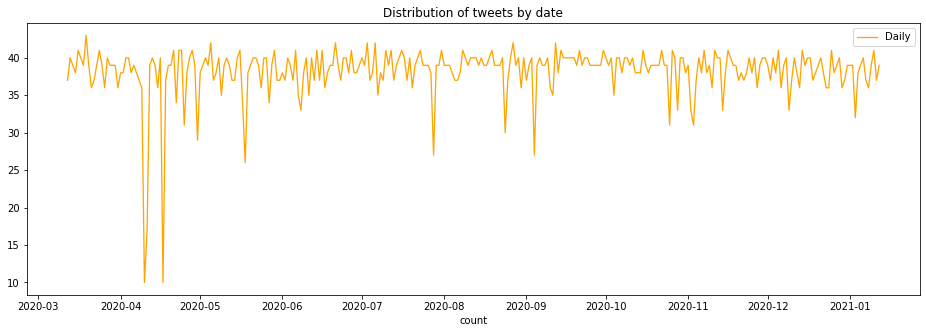

In [21]:
# 数据量随日期分布的折线图，可以看到某些日期的数据量较少，总体来说相对均匀
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches(16,5)

plt.plot(day_data['publish_time'], day_data['times'], linewidth=1.3, label='Daily', color='orange')
ax.set(xlabel='count',title='Distribution of tweets by date')
plt.legend()
plt.show()

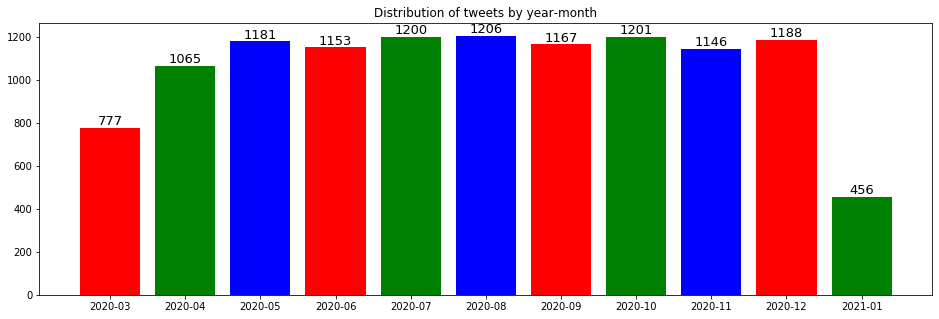

In [22]:
# 数据量随月份分布的柱状图，可以看到2020-3和2021-1的数据量较少，其他月份数据量都较均匀
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches(16,5)
rects = plt.bar \
(range(len(month_data['month'])), month_data['times'], tick_label=month_data['year_month'], color='rgb')

# 打数据标注
for rect in rects:  #rects 是三根柱子的集合
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=13, ha='center', va='bottom')

plt.title('Distribution of tweets by year-month')
plt.show()

In [23]:
# plt.figure(figsize=(10,10))
# plt.hist(Twitter_data['publish_time'], density=True, bins='auto',align='left')

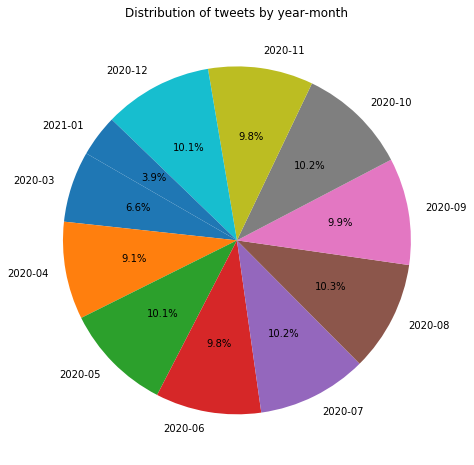

In [24]:
# 数据量随月份分布的饼图
fig = plt.figure()
fig.set_size_inches(8,8)

plt.pie(month_data['times'],labels=month_data['year_month'],autopct='%1.1f%%',shadow=False,startangle=150)
plt.title('Distribution of tweets by year-month')
plt.show()

#### 数据分布情况：2020-3和2021-1的数据量较少，其他月份数据量都较均匀

## 二、文本预处理

In [25]:
# print(string.punctuation)

def text_preprocess(data):
    # 去除@user
    processed_data = data.map(lambda x: re.sub(r'@[\w]*', '', x))

    # 去除网址
    processed_data = processed_data.map(lambda x: re.sub(r'http.*\..* ', '', x))

    # 去除标点符号
    processed_data = processed_data.map(lambda x: re.sub(r'[^a-zA-Z ]', '', x))

    # 删除长度太短的词（通常无意义）
    processed_data = processed_data.map(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

    # 分词
    processed_data = processed_data.map(lambda x: nltk.WordPunctTokenizer().tokenize(x))

    return processed_data

In [26]:
# 去除标点、@、短词，进行分词
Processed_data = text_preprocess(Twitter_data['content'])

In [27]:
# 经过预处理后的单词矩阵
Processed_data.head()

0    [This, incredibly, harmful, there, fucking, va...
1    [Doesnt, compare, people, have, immunity, many...
2    [seen, soooo, many, articles, about, damn, ant...
3    [Therush, create, vaccinefor, covid, rather, t...
4    [Please, your, vaccine, wash, your, hands, ove...
Name: content, dtype: object

In [28]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


False

In [29]:
# 查看停用词词典
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [30]:
# 去除停用词
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


# 去除停用词
data_words = remove_stopwords(Processed_data)


In [31]:
# 去除停用词后的单词矩阵
data_words

[['incredibly',
  'harmful',
  'fucking',
  'vaccine',
  'doesnt',
  'always',
  'work',
  'helps',
  'used',
  'covid',
  'like',
  'days',
  'identified'],
 ['doesnt',
  'compare',
  'people',
  'immunity',
  'many',
  'vaccinated',
  'still',
  'lose',
  'year',
  'theres',
  'immunity',
  'vaccine',
  'covid',
  'people',
  'risk',
  'wash',
  'hands',
  'sing',
  'happy',
  'birthday'],
 ['seen',
  'soooo',
  'many',
  'articles',
  'damn',
  'antivaxxers',
  'shouting',
  'forced',
  'covid',
  'vaccine',
  'created'],
 ['therush',
  'create',
  'vaccinefor',
  'covid',
  'rather',
  'invest',
  'publichealth',
  'shows',
  'leaders',
  'remain',
  'reactive',
  'rather',
  'proactive'],
 ['please',
  'vaccine',
  'wash',
  'hands',
  'secs',
  'coughsneeze',
  'elbow',
  'many',
  'basic',
  'proximity',
  'quarantine',
  'lots',
  'covid',
  'isnt'],
 ['heres',
  'deal',
  'probably',
  'going',
  'contract',
  'covid',
  'resources',
  'must',
  'place',
  'help',
  'vulnerabl

In [32]:
# 去除搜索关键词



In [33]:
# 导入下面三种词干提取器进行对比
import nltk.stem.porter as pt
import nltk.stem.lancaster as lc
import nltk.stem.snowball as sb

# 导入nltk.stem用来词型还原
import nltk.stem as ns

def word_stem(text_matrix):

    print("----------词干提取-------------")
    # 在名词和动词中，除了与数和时态有关的成分以外的核心成分。
    # 词干并不一定是合法的单词

    pt_stemmer = pt.PorterStemmer()  # 波特词干提取器
    lc_stemmer = lc.LancasterStemmer()   # 兰卡斯词干提取器
    sb_stemmer = sb.SnowballStemmer("english")# 思诺博词干提取器
    
    

    print("%8s %8s %8s %8s" % ('word','pt_stem','lc_stem','sb_stem'))
    for index_txt, text in enumerate(tqdm(text_matrix)):
        for index_word, word in enumerate(text):
            pt_stem = pt_stemmer.stem(word)
            lc_stem = lc_stemmer.stem(word)
            sb_stem = sb_stemmer.stem(word)
            if index_txt==1 and index_word<10:
                print("%8s %8s %8s %8s" % (word,pt_stem,lc_stem,sb_stem))
            




In [34]:
# 展示一下词干提取的结果，但实际并没有使用词干提取，因为粒度过粗
word_stem(data_words)

----------词干提取-------------
    word  pt_stem  lc_stem  sb_stem


  0%|                                                                                        | 0/11740 [00:00<?, ?it/s]

  doesnt   doesnt   doesnt   doesnt
 compare   compar     comp   compar
  people    peopl    peopl    peopl
immunity    immun    immun    immun
    many     mani     many     mani
vaccinated   vaccin   vaccin   vaccin
   still    still     stil    still
    lose     lose      los     lose
    year     year     year     year
  theres    there     ther    there


100%|██████████████████████████████████████████████████████████████████████████| 11740/11740 [00:08<00:00, 1400.51it/s]


In [35]:
# 词型还原：复数名词->单数名词 ；分词->动词原型
# 单词原型一定是合法的单词

def word_lemma(text_matrix): 
    print("----------词型还原器---------------")
    
    print("%8s %8s %8s" % ('word','n_lemma','v_lemma'))
    lemmatizer = ns.WordNetLemmatizer()
    for index_txt, text in enumerate(tqdm(text_matrix)):
        for index_word, word in enumerate(text):
            # 将名词还原为单数形式
            n_lemma = lemmatizer.lemmatize(word, pos='n')
            # 将动词还原为原型形式
            v_lemma = lemmatizer.lemmatize(word, pos='v')
            if index_txt == 1 and index_word < 10:
                print('%8s %8s %8s' % (word, n_lemma, v_lemma))
            
            if(len(n_lemma)<len(v_lemma)):
                text_matrix[index_txt][index_word] = n_lemma
            else:
                text_matrix[index_txt][index_word] = v_lemma
                
    return text_matrix
            

In [36]:
# 实际使用了粒度更细的词形还原
data_words = word_lemma(data_words)

----------词型还原器---------------
    word  n_lemma  v_lemma


  0%|                                                                              | 1/11740 [00:01<5:53:39,  1.81s/it]

  doesnt   doesnt   doesnt
 compare  compare  compare
  people   people   people
immunity immunity immunity
    many     many     many
vaccinated vaccinated vaccinate
   still    still    still
    lose     lose     lose
    year     year     year
  theres    there   theres


100%|██████████████████████████████████████████████████████████████████████████| 11740/11740 [00:02<00:00, 4012.84it/s]


In [37]:
# 经过词形还原后的单词矩阵
data_words

[['incredibly',
  'harmful',
  'fuck',
  'vaccine',
  'doesnt',
  'always',
  'work',
  'help',
  'use',
  'covid',
  'like',
  'day',
  'identify'],
 ['doesnt',
  'compare',
  'people',
  'immunity',
  'many',
  'vaccinate',
  'still',
  'lose',
  'year',
  'there',
  'immunity',
  'vaccine',
  'covid',
  'people',
  'risk',
  'wash',
  'hand',
  'sing',
  'happy',
  'birthday'],
 ['see',
  'soooo',
  'many',
  'article',
  'damn',
  'antivaxxers',
  'shout',
  'force',
  'covid',
  'vaccine',
  'create'],
 ['therush',
  'create',
  'vaccinefor',
  'covid',
  'rather',
  'invest',
  'publichealth',
  'show',
  'leader',
  'remain',
  'reactive',
  'rather',
  'proactive'],
 ['please',
  'vaccine',
  'wash',
  'hand',
  'sec',
  'coughsneeze',
  'elbow',
  'many',
  'basic',
  'proximity',
  'quarantine',
  'lot',
  'covid',
  'isnt'],
 ['here',
  'deal',
  'probably',
  'go',
  'contract',
  'covid',
  'resource',
  'must',
  'place',
  'help',
  'vulnerable',
  'resource',
  'divert'

In [38]:
# 去除搜索关键词相关的单词
ban_words_list = []
with open('./ban_words_list.txt') as f:
    for line in f.readlines():
        ban_words_list.append(line.strip('\n'))

In [39]:
ban_words_list

['vaccine', 'vaccines', 'covid', 'covidvaccine', 'coronavirus', 'virus']

In [40]:
def remove_search_words(words_matrix, ban_words_list):
    words_processed = []
    for text in words_matrix:
        words_text = []
        for word in text:
            if word not in ban_words_list:
                words_text.append(word)
                
        words_processed.append(words_text)
        
    return words_processed
    

In [41]:
data_words = remove_search_words(data_words, ban_words_list)

In [42]:
data_words

[['incredibly',
  'harmful',
  'fuck',
  'doesnt',
  'always',
  'work',
  'help',
  'use',
  'like',
  'day',
  'identify'],
 ['doesnt',
  'compare',
  'people',
  'immunity',
  'many',
  'vaccinate',
  'still',
  'lose',
  'year',
  'there',
  'immunity',
  'people',
  'risk',
  'wash',
  'hand',
  'sing',
  'happy',
  'birthday'],
 ['see',
  'soooo',
  'many',
  'article',
  'damn',
  'antivaxxers',
  'shout',
  'force',
  'create'],
 ['therush',
  'create',
  'vaccinefor',
  'rather',
  'invest',
  'publichealth',
  'show',
  'leader',
  'remain',
  'reactive',
  'rather',
  'proactive'],
 ['please',
  'wash',
  'hand',
  'sec',
  'coughsneeze',
  'elbow',
  'many',
  'basic',
  'proximity',
  'quarantine',
  'lot',
  'isnt'],
 ['here',
  'deal',
  'probably',
  'go',
  'contract',
  'resource',
  'must',
  'place',
  'help',
  'vulnerable',
  'resource',
  'divert',
  'normal',
  'health',
  'care',
  'system',
  'major',
  'effort',
  'ongoing',
  'produce',
  'effective'],
 ['kn

## TF-IDF（关键词权重）与LDA（词分布）的区别

> 使用TF-IDF进行关键词提取的局限性在于: 在某些场景，基于文档本身的关键词提取还不是非常足够，有些关键词并不一定会显示地出现在文档当中，如一篇讲动物生存环境的科普文，通篇介绍狮子老虎等，但是文中并没有显示地出现动物二字。

> 而LDA主题模型认为在词与文档之间没有直接的联系，它们应当还有一个维度将它们串联起来，主题模型将这个维度称为主题。每个文档都应该对应着一个或多个的主题，而每个主题都会有对应的词分布，通过主题，就可以得到每个文档的词分布。

## 词云分析

基于TF-IDF算法生成词云


### 词袋模型(bag of words)
- 将每一篇文档视为一个词频向量，从而将文本信息转化为了易于建模的数字信息
- 词袋方法没有考虑词与词之间的顺序，这简化了问题的复杂性，同时也为模型的改进提供了契机

In [43]:
# 构造词典（将单词词典化，编号和单词具有一一对应关系）
dictionary = corpora.Dictionary(data_words)

texts = data_words

# 统计词频，构造词频矩阵（词袋）
corpus = [dictionary.doc2bow(text) for text in texts]


In [44]:
# 构造TF-IDF模型
tf_idf_model = TfidfModel(corpus, normalize=True)
word_tf_idf = list(tf_idf_model[corpus])

In [45]:
# 词典
dictionary.token2id

{'always': 0,
 'day': 1,
 'doesnt': 2,
 'fuck': 3,
 'harmful': 4,
 'help': 5,
 'identify': 6,
 'incredibly': 7,
 'like': 8,
 'use': 9,
 'work': 10,
 'birthday': 11,
 'compare': 12,
 'hand': 13,
 'happy': 14,
 'immunity': 15,
 'lose': 16,
 'many': 17,
 'people': 18,
 'risk': 19,
 'sing': 20,
 'still': 21,
 'there': 22,
 'vaccinate': 23,
 'wash': 24,
 'year': 25,
 'antivaxxers': 26,
 'article': 27,
 'create': 28,
 'damn': 29,
 'force': 30,
 'see': 31,
 'shout': 32,
 'soooo': 33,
 'invest': 34,
 'leader': 35,
 'proactive': 36,
 'publichealth': 37,
 'rather': 38,
 'reactive': 39,
 'remain': 40,
 'show': 41,
 'therush': 42,
 'vaccinefor': 43,
 'basic': 44,
 'coughsneeze': 45,
 'elbow': 46,
 'isnt': 47,
 'lot': 48,
 'please': 49,
 'proximity': 50,
 'quarantine': 51,
 'sec': 52,
 'care': 53,
 'contract': 54,
 'deal': 55,
 'divert': 56,
 'effective': 57,
 'effort': 58,
 'go': 59,
 'health': 60,
 'here': 61,
 'major': 62,
 'must': 63,
 'normal': 64,
 'ongoing': 65,
 'place': 66,
 'probably': 67

In [46]:
# 词频（每一行代表一篇推文，某一行中的某个元组对（x,y）代表编号为x的单词在该推文中出现了y次）
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1)],
 [(2, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 2),
  (16, 1),
  (17, 1),
  (18, 2),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1)],
 [(17, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1)],
 [(28, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1)],
 [(13, 1),
  (17, 1),
  (24, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1)],
 [(5, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1)],
 [(21, 1),
  (53, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82

In [47]:
# 每个句子对应的词袋 (前面是单词，后面是词频)
# 词频矩阵反向化（id->单词）

id_words = [[(dictionary[id], count) for id, count in line] for line in corpus]
print(data_words[1])
print(id_words[1])

['doesnt', 'compare', 'people', 'immunity', 'many', 'vaccinate', 'still', 'lose', 'year', 'there', 'immunity', 'people', 'risk', 'wash', 'hand', 'sing', 'happy', 'birthday']
[('doesnt', 1), ('birthday', 1), ('compare', 1), ('hand', 1), ('happy', 1), ('immunity', 2), ('lose', 1), ('many', 1), ('people', 2), ('risk', 1), ('sing', 1), ('still', 1), ('there', 1), ('vaccinate', 1), ('wash', 1), ('year', 1)]


In [48]:
# TF-IDF得分，每篇推文中每个单词都有对应的TF_IDF得分，该得分已经进行了标准化，可以视作一个单词的权重
word_tf_idf

[[(0, 0.3394518289134151),
  (1, 0.28641444186675413),
  (2, 0.26865608649753747),
  (3, 0.33059505929234045),
  (4, 0.3649623509602435),
  (5, 0.21730104740409978),
  (6, 0.3498791083201729),
  (7, 0.42970824732177504),
  (8, 0.2073633935327745),
  (9, 0.24460080516862417),
  (10, 0.1759519120488025)],
 [(2, 0.19966866981149556),
  (11, 0.36232572003807967),
  (12, 0.2644928207073245),
  (13, 0.2457025135581999),
  (14, 0.2731088689855157),
  (15, 0.34077978571888157),
  (16, 0.23111055411905246),
  (17, 0.17520800889878435),
  (18, 0.2346555273185464),
  (19, 0.19431230089382748),
  (20, 0.36232572003807967),
  (21, 0.16286273157906792),
  (22, 0.19368656598851303),
  (23, 0.20299690560867759),
  (24, 0.27124472814866213),
  (25, 0.14414038518591946)],
 [(17, 0.21969493780015223),
  (26, 0.32098653057788085),
  (27, 0.2829174320747385),
  (28, 0.23873958815959712),
  (29, 0.34489511305458553),
  (30, 0.24860872886438443),
  (31, 0.2768086866627394),
  (32, 0.4765925561093737),
  (33,

In [49]:
# 基于TF-IDF算法提取关键词
def TF_IDF_get_keywords(words_matrix, top_n=3):
    # 构建词袋模型

    # 构造词典（将单词词典化，编号和单词具有一一对应关系）
    dictionary = corpora.Dictionary(words_matrix)

    texts = words_matrix

    # 统计词频，构造词频矩阵（词袋）
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    tf_idf_model = TfidfModel(corpus, normalize=True)
    word_tf_idf = list(tf_idf_model[corpus])
    
    key_words_matrix = []
    
    for index_txt, text in enumerate(tqdm(word_tf_idf)):
        text.sort(key=lambda x: x[1], reverse=True)
        key_words_code = [word[0] for word in text[:top_n+3]]
        key_words = []
#         print(key_words_code)
        for code in key_words_code:
            if dictionary[code] not in ban_words_list:
                key_words.append(dictionary[code])
            if len(key_words)>=3:
                break
        
        if index_txt<5:
            print('tweet %d \'s keywords: ' % index_txt)
            print(key_words)
            print()
            
        key_words_matrix.append(key_words)
    
    return key_words_matrix
        
    
    

In [50]:
# 提取每篇推文Top3的TF-IDF得分的关键词
key_words_global = TF_IDF_get_keywords(data_words)

  0%|                                                                                        | 0/11740 [00:00<?, ?it/s]

tweet 0 's keywords: 
['incredibly', 'harmful', 'identify']

tweet 1 's keywords: 
['birthday', 'sing', 'immunity']

tweet 2 's keywords: 
['shout', 'soooo', 'damn']

tweet 3 's keywords: 
['rather', 'reactive', 'therush']

tweet 4 's keywords: 
['coughsneeze', 'elbow', 'proximity']



100%|█████████████████████████████████████████████████████████████████████████| 11740/11740 [00:00<00:00, 95682.59it/s]


In [51]:
key_words_global

[['incredibly', 'harmful', 'identify'],
 ['birthday', 'sing', 'immunity'],
 ['shout', 'soooo', 'damn'],
 ['rather', 'reactive', 'therush'],
 ['coughsneeze', 'elbow', 'proximity'],
 ['resource', 'divert', 'ongoing'],
 ['kirkland', 'suppression', 'smaller'],
 ['soon', 'vanity', 'fair'],
 ['elderly', 'stronger', 'evolve'],
 ['rate', 'morality', 'context'],
 ['barely', 'mortality', 'seasonal'],
 ['declaration', 'word', 'widely'],
 ['recover', 'need', 'foolscovid'],
 ['imagine', 'realize', 'pray'],
 ['overcharge', 'lick', 'turtle'],
 ['fluthis', 'progressflu', 'flu'],
 ['newprofilepic'],
 ['herd', 'also', 'immunity'],
 ['pertinent', 'jeff', 'victim'],
 ['breed', 'mainly', 'grind'],
 ['sniffle', 'significantly', 'mortality'],
 ['happen', 'immunise', 'possibility'],
 ['askcdc', 'laboratory', 'battle'],
 ['soross', 'grave', 'soros'],
 ['american', 'insurance', 'polio'],
 ['longer', 'hop', 'develop'],
 ['extensive', 'proprietary', 'platform'],
 ['rico', 'puerto', 'manufacture'],
 ['swear', 'vax

In [52]:
# 提取高频关键词
def get_highest_frequency_words(words, top_n=10):
    frequency = {}
    for word in words:
        if word in frequency:
            frequency[word] += 1
        else:
            frequency[word] = 1
    
#     print(frequency)
    top_words = sorted(frequency.items(), key=lambda x: x[1],reverse=True)[:top_n]
    
#     print(top_words)
    top_words_dict = {}
    for word in top_words:
        top_words_dict[word[0]] = word[1]
        
        
    return top_words_dict

In [53]:
# 提取每个月出现频率最高的关键词
key_words_global_general = {}

key_words = []
for text in key_words_global:
    for word in text:
        key_words.append(word)
    
# print(key_words)

key_words_global_general = get_highest_frequency_words(key_words, top_n=GLOBAL_TOP_N)

# 将Top20关键词输出至./keywords/global/Top20_keywords_global.txt文件中
if not os.path.exists('./key_words/global'):
    os.makedirs('./key_words/global')

with open('./key_words/global/Top20_keywords_global.txt', 'w') as f:
    f.truncate(0)
    for key_word in key_words_global_general:
        f.write(key_word+' '+str(key_words_global_general[key_word])+'\n')
    

In [54]:
key_words_global_general

{'johnson': 69,
 'russia': 50,
 'race': 45,
 'volunteer': 43,
 'promise': 41,
 'here': 41,
 'trump': 40,
 'take': 40,
 'sign': 39,
 'trial': 38,
 'result': 38,
 'news': 37,
 'early': 37,
 'ready': 37,
 'oxford': 37,
 'begin': 36,
 'know': 36,
 'candidate': 35,
 'available': 35,
 'first': 34}

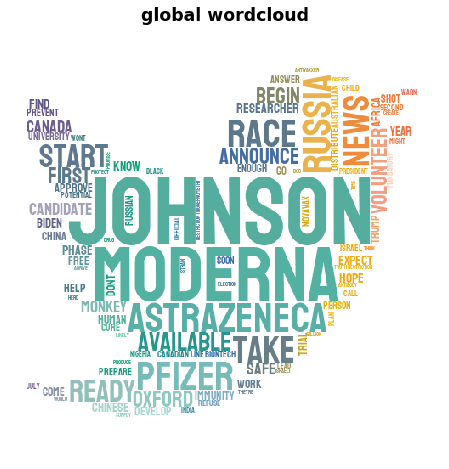

In [55]:
# 生成全局词云

# 连接全局关键词矩阵中所有单词
global_string =  ' '.join([' '.join(word) for word in key_words_global])

# # Create a WordCloud object
# wordcloud = WordCloud \
# (height=400, width=800, background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

# 
# wordcloud.generate(global_string)
# wordcloud.to_image()
# if not os.path.exists('./word_cloud/global/wordcloud_global.png'):
#     wordcloud.to_file('./word_cloud/global/wordcloud_global.png')


if not os.path.exists('./word_cloud/global'):
    os.makedirs('./word_cloud/global')

# 生成词云    
    
if not os.path.exists('./word_cloud/global/wordcloud_global.png'):
    
    stylecloud.gen_stylecloud( 
        text=global_string, 
        icon_name="fab fa-twitter", # 使用推特图标蒙版
        gradient='horizontal', # 渐变色方向选了垂直方向
        max_words=200,
        output_name='./word_cloud/global/wordcloud_global.png',
    )

# 词云可视化

img = Image.open('./word_cloud/global/wordcloud_global.png')
    
fig = plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.title('global wordcloud', fontsize='xx-large',fontweight='heavy')
plt.show()

In [56]:
month_data['times']

0      777
1     1065
2     1181
3     1153
4     1200
5     1206
6     1167
7     1201
8     1146
9     1188
10     456
Name: times, dtype: int64

In [57]:
# 逐月分割关键词矩阵
'''
input: 单词矩阵（分词后的单词 / 提取后的关键词矩阵）, shape:
       逐月数据条数（每个月有多少条数据，前面已经统计过了）, 
       具体月份（这里使用year-month）
       
output: 逐月分割后的单词矩阵（增加了一个维度） 
'''

def words_separate_by_month(words_matrix, times_by_month, year_month):
    '''
    @description: 
    @param 
    @return: 
    '''
    
    key_words_by_month = {}
    
    global_index = 0
    
    for index, times in enumerate(times_by_month):
        key_words_per_month = []
        for i in range(times):
            key_words_per_month.append(words_matrix[global_index])
            global_index += 1
            
        key_words_by_month[year_month[index]] = key_words_per_month
    
    
    return key_words_by_month

In [58]:
# 生成逐月词云
key_words_by_month = words_separate_by_month(key_words_global, month_data['times'], month_data['year_month'])

In [59]:
# 2020年11月的前5条数据
key_words_by_month['2020-11'][:5]

[['imposible', 'responsability', 'instruction'],
 ['march', 'frontline', 'here'],
 ['latestage', 'monitor', 'knowledge'],
 ['reset', 'expectation', 'well'],
 ['huntreveals', 'greg', 'march']]

In [60]:
# 提取每个月出现频率最高的关键词
key_words_by_month_general = {}

for year_month in key_words_by_month.keys():
    key_words_per_month = []
    for text in key_words_by_month[year_month]:
        for word in text:
            key_words_per_month.append(word)
    
#     print(key_words_per_month)
    
    key_words_by_month_general[year_month] = get_highest_frequency_words \
    (key_words_per_month, top_n=PER_MONTH_TOP_N)
    
    if not os.path.exists('./key_words/per_month'):
        os.makedirs('./key_words/per_month')


    with open('./key_words/per_month/Top10_keywords_'+year_month+'.txt', 'w') as f:
        f.truncate(0)
        for key_word in key_words_by_month_general[year_month]:
            f.write(key_word+' '+str(key_words_by_month_general[year_month][key_word])+'\n')
    

In [61]:
# 每个月的top10关键词
pprint(key_words_by_month_general)

{'2020-03': {'antivaxxers': 6,
             'clinical': 8,
             'develop': 8,
             'dose': 9,
             'fight': 6,
             'find': 7,
             'immunity': 8,
             'investigational': 7,
             'johnson': 11,
             'monday': 9},
 '2020-04': {'africa': 11,
             'close': 9,
             'dont': 12,
             'every': 12,
             'expert': 14,
             'monkey': 9,
             'protect': 17,
             'save': 11,
             'system': 11,
             'together': 12},
 '2020-05': {'chinese': 9,
             'ease': 9,
             'know': 10,
             'need': 9,
             'rapid': 13,
             'restriction': 9,
             'say': 10,
             'trump': 13,
             'way': 10,
             'year': 9},
 '2020-06': {'brazil': 11,
             'colorado': 10,
             'equal': 17,
             'everywhere': 17,
             'fuel': 16,
             'globalgoalunite': 18,
             'rally': 15,
 

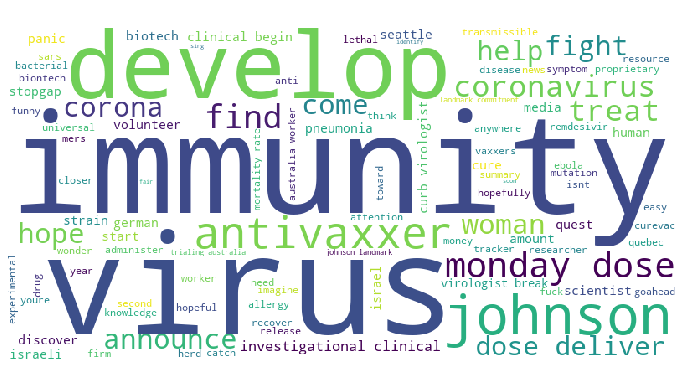

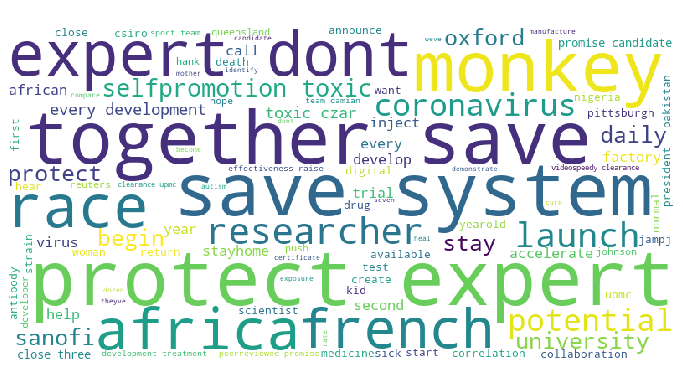

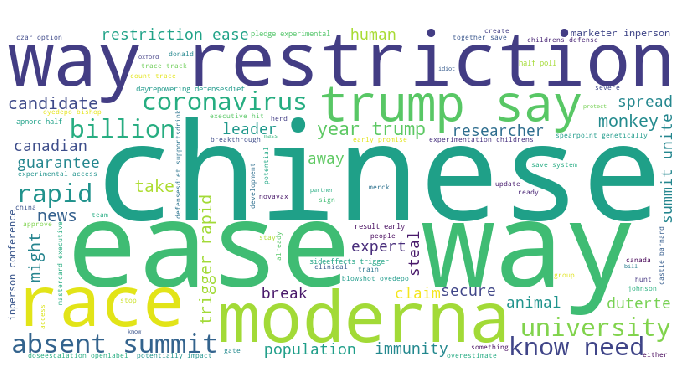

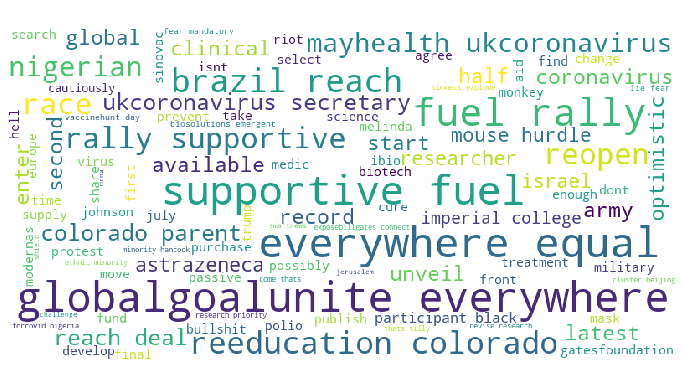

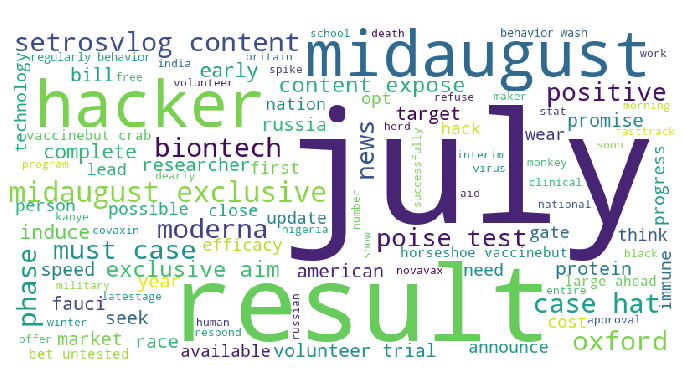

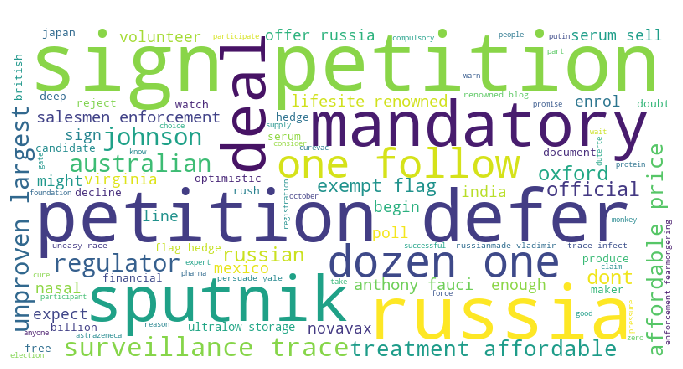

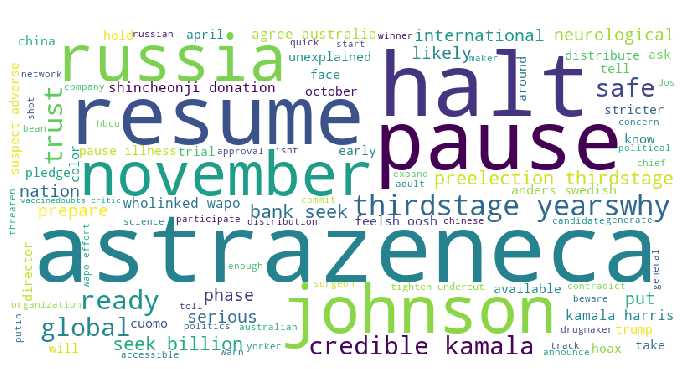

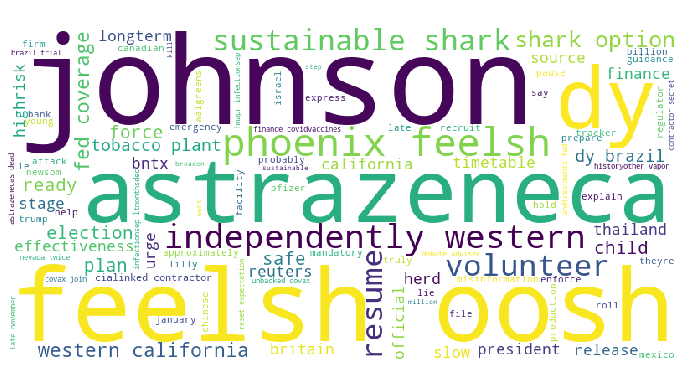

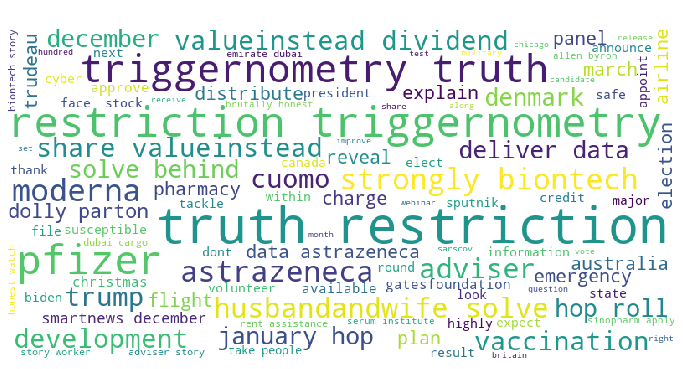

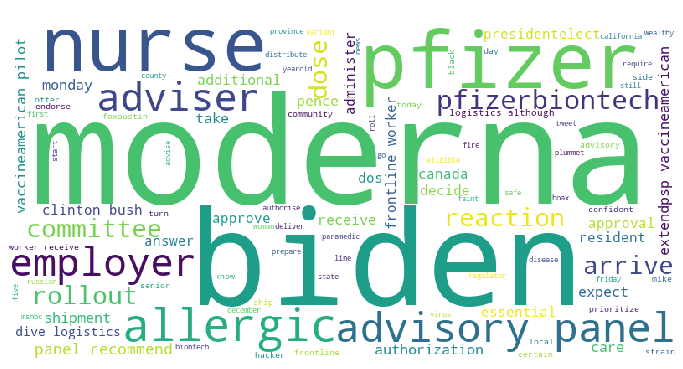

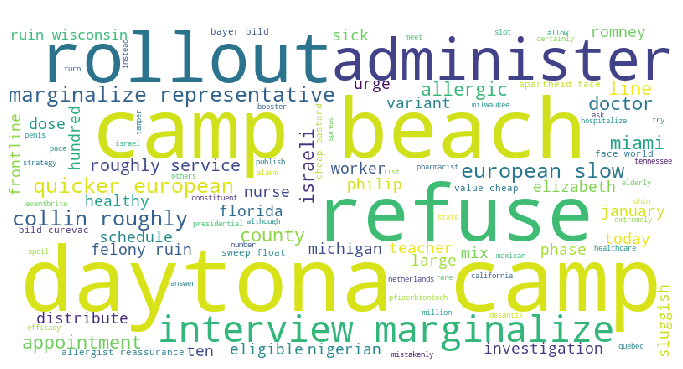

In [62]:
# 生成逐月词云

for year_month in key_words_by_month.keys():
    
    # 连接逐月关键词矩阵中所有单词
    per_month_string = ' '.join([' '.join(x) for x in key_words_by_month[year_month]])

#     print(len(per_month_string))
    # Create a WordCloud object
    wordcloud = WordCloud \
    (height=400, width=800, background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

    # 生成词云
    wordcloud.generate(per_month_string)

    if not os.path.exists('./word_cloud/per_month'):
        os.makedirs('./word_cloud/per_month')
    
    if not os.path.exists('./word_cloud/per_month/wordcloud_'+year_month+'.png'):
        wordcloud.to_file('./word_cloud/per_month/wordcloud_'+year_month+'.png')
    
    
    img = Image.open('./word_cloud/per_month/wordcloud_'+year_month+'.png')
    
    fig = plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('word cloud of %s' % year_month, fontsize='xx-large',fontweight='heavy',color='white')
    plt.show()

## 什么是LDA主题模型?

在LDA中，所有的文档共有同样的话题集，但是每个文档以不同的比例展示对应的话题。LDA的主要目标是自动发现一个文档集合中的话题。这些文档本身是可以观测到的，而话题的结构——话题、每个文档的话题分布和每个文档的每个词的话题赋值——是隐藏的（可称为hidden structure）。话题建模的核心计算问题就是使用观测到的文档来推断隐藏话题结构。这也可以看作是生成（generative）过程的逆过程——什么样的隐藏结构可以产生观测到的文档集合？


### LDA模型训练

默认设置有5个topic

期望topic在四个象限分布越均匀越好，代表覆盖得越全面

若topic之间隔的太远，则增大topic的数量

若不同topic之间有较大的重叠，则减少topic的数量


In [63]:
# 读取或创建lda模型
if not os.path.exists('./lda_model'):
    os.makedirs('./lda_model')

if os.path.exists('./lda_model/lda.model'):
    lda_model = LdaModel.load('./lda_model/lda.model')
else:

    # 设定的主题数目
    num_topics = NUM_TOPICS
    iterations = ITERATIONS

    # 构建LDA模型
    lda_model = gensim.models.LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics
    )

    lda_model.save('./lda_model/lda.model')

    
topic_list = lda_model.print_topics(num_words=10)
# doc_lda = lda_model[corpus]

In [64]:
# 主题分布
topic_list

[(0,
  '0.015*"trial" + 0.008*"people" + 0.007*"test" + 0.007*"take" + 0.006*"trump" + 0.005*"make" + 0.005*"health" + 0.004*"development" + 0.004*"news" + 0.004*"state"'),
 (1,
  '0.009*"first" + 0.007*"trump" + 0.007*"trial" + 0.005*"test" + 0.005*"people" + 0.005*"scientist" + 0.004*"say" + 0.004*"could" + 0.004*"treatment" + 0.004*"need"'),
 (2,
  '0.010*"say" + 0.008*"people" + 0.007*"trump" + 0.007*"work" + 0.006*"trial" + 0.006*"test" + 0.006*"year" + 0.006*"news" + 0.005*"world" + 0.005*"first"'),
 (3,
  '0.010*"say" + 0.007*"develop" + 0.007*"make" + 0.006*"take" + 0.006*"work" + 0.006*"trial" + 0.005*"health" + 0.005*"people" + 0.005*"plan" + 0.005*"could"')]

In [65]:
# 模型困惑度得分
# 得分越低说明模型对文本越不困惑
print('Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.

# Compute Coherence Score
# 模型一致性得分
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -8.3371759591918
Coherence Score:  0.14945897203960157


In [66]:
# 格式化输出所有主题构成（概率分布）
if not os.path.exists('./lda_topics'):
    os.makedirs('./lda_topics')
    
with open('./lda_topics/topics.txt', 'w') as f:
    f.truncate(0)
    for topic in topic_list:
        f.write('topic %d:\n' % topic[0])
        for word in topic[1].split('+'):
#                 print(word)
            f.write('  {}  {}\n'.format(word.split('*')[1], word.split('*')[0]))

        f.write('\n')
    
    

In [67]:
# 每个文档都包含多个主题。但是，通常只有一个主题是主导的。
# 下面的代码为每个句子提取该主要主题，并在格式正确的输出中显示该主题和关键字的权重。
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(tqdm(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append\
                (pd.Series([int(topic_num),round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    # print(contents)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    # print(sent_topics_df)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']



df_dominant_topic.to_csv('./lda_topics/dominant_topics.csv',index=False)

100%|███████████████████████████████████████████████████████████████████████████| 11740/11740 [00:48<00:00, 241.39it/s]


In [68]:
# 使用LDA对每篇推文的主要主题筛选
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text
0,0,2.0,0.9336,"say, people, trump, work, trial, test, year, n...","[incredibly, harmful, fuck, doesnt, always, wo..."
1,1,0.0,0.5585,"trial, people, test, take, trump, make, health...","[doesnt, compare, people, immunity, many, vacc..."
2,2,0.0,0.5699,"trial, people, test, take, trump, make, health...","[see, soooo, many, article, damn, antivaxxers,..."
3,3,3.0,0.9396,"say, develop, make, take, work, trial, health,...","[therush, create, vaccinefor, rather, invest, ..."
4,4,1.0,0.9401,"first, trump, trial, test, people, scientist, ...","[please, wash, hand, sec, coughsneeze, elbow, ..."
...,...,...,...,...,...
11735,11735,2.0,0.7609,"say, people, trump, work, trial, test, year, n...","[ottawa, pay, deloitte, million, dollar, devel..."
11736,11736,3.0,0.8427,"say, develop, make, take, work, trial, health,...","[maine, say, sit, shelf]"
11737,11737,1.0,0.9383,"first, trump, trial, test, people, scientist, ...","[indonesia, give, sinovac, biotech, first, eme..."
11738,11738,2.0,0.9662,"say, people, trump, work, trial, test, year, n...","[bromleag, care, practice, part, bgpa, hard, w..."


## LDA可视化
- 每个主题的意义（右边的单词为某个主题下常出现的单词）
- 每个主题在总语料库中的比重
- 主题之间的关联


In [69]:
# LDA模型可视化

vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

### 情感词典法计算文本情感得分

1. 确定否定词词典、程度副词词典

2. 判断每个情感词前是否有否定词或程度副词，将它之前的否定词和程度副词划分为一个组，如果有否定词将情感词的情感权值乘以-1，如果有程度副词就乘以程度副词的程度值，最后所有组的得分加起来，大于0的归于正向，小于0的归于负向

3. 数据统计结果分析 




在此，简化的情感分数计算逻辑：所有**情感词语组**的分数之和

定义一个情感词语组：两情感词之间的所有否定词和程度副词与这两情感词中的后一情感词构成一个情感词组，即negative_word + degree_word + sentiment_word构成一个情感词组

In [70]:
# 导入三种词典
degree_df = pd.read_csv('./dictionaries/degree_dictionary/degree_dictionary.csv')
negative_df = pd.read_csv('./dictionaries/negative_dictionary/negative_dictionary.csv')
sentiment_df = pd.read_csv('./dictionaries/sentiment_dictionary/SentiWordNet3.0.0.csv')

In [71]:
sentiment_df

,word,attr,score
0,able,a,0.079091
1,unable,a,-0.363636
2,dorsal,a,0.000000
3,abaxial,a,0.000000
4,ventral,a,0.000000
...,...,...,...
155282,shade_off,v,0.000000
155283,cloud_up,v,-0.250000
155284,blight,v,-0.250000
155285,run_dry,v,0.000000


In [72]:
degree_df

,word,weight
0,absolute,2.0
1,absolutely,2.0
2,alarmingly,2.0
3,amazingly,2.0
4,astonishingly,2.0
...,...,...
103,light,0.8
104,merely,0.8
105,relative,0.8
106,slight,0.8


In [73]:
negative_df

,word
0,no
1,not
2,none
3,never
4,nothing
5,nobody
6,neither
7,didnt
8,dont
9,doesnt


In [74]:
data_words

[['incredibly',
  'harmful',
  'fuck',
  'doesnt',
  'always',
  'work',
  'help',
  'use',
  'like',
  'day',
  'identify'],
 ['doesnt',
  'compare',
  'people',
  'immunity',
  'many',
  'vaccinate',
  'still',
  'lose',
  'year',
  'there',
  'immunity',
  'people',
  'risk',
  'wash',
  'hand',
  'sing',
  'happy',
  'birthday'],
 ['see',
  'soooo',
  'many',
  'article',
  'damn',
  'antivaxxers',
  'shout',
  'force',
  'create'],
 ['therush',
  'create',
  'vaccinefor',
  'rather',
  'invest',
  'publichealth',
  'show',
  'leader',
  'remain',
  'reactive',
  'rather',
  'proactive'],
 ['please',
  'wash',
  'hand',
  'sec',
  'coughsneeze',
  'elbow',
  'many',
  'basic',
  'proximity',
  'quarantine',
  'lot',
  'isnt'],
 ['here',
  'deal',
  'probably',
  'go',
  'contract',
  'resource',
  'must',
  'place',
  'help',
  'vulnerable',
  'resource',
  'divert',
  'normal',
  'health',
  'care',
  'system',
  'major',
  'effort',
  'ongoing',
  'produce',
  'effective'],
 ['kn

词语分类，记录位置

In [75]:
# 情感定位
def classify_words(text, sentiment_df, negative_df, degree_df):
    sentiment_dict = {}
    negative_words = []
    degree_dict = {}
    
    for index_word, word in enumerate(text):

        if \
        word in sentiment_df['word'].tolist() \
        and word not in negative_df['word'].tolist() \
        and word not in degree_df['word'].tolist():
            sentiment_dict[word] = sentiment_df[sentiment_df['word']==word]['score'].tolist()[0]

        elif word in negative_df['word'].tolist():
            negative_words.append(word)

        elif word in degree_df['word'].tolist():
            degree_dict[word] = degree_df[degree_df['word']==word]['weight'].tolist()[0]
            
    return sentiment_dict, negative_words, degree_dict
    
    

In [76]:
# 情感聚合，计算情感得分
def compute_sentiment_score(words_matrix, sentiment_df, negative_df, degree_df):
    scores = []
    
    for index_txt, text in enumerate(tqdm(words_matrix)):
        # senLoc是在情感词词组中的指针，对于每篇推文要重新初始化
        senLoc_pre = -1
        senLoc = -1
        # 每篇推文对应一个总得分，对于每篇推文需要重新初始化
        score = 0
        
        weight = 1
        degree = 1
        
        
        # 对每篇推文划分词类
        sentiment_dict, negative_words, degree_dict = \
        classify_words(text, sentiment_df, negative_df, degree_df)
        
        sentiment_words = [key for key in sentiment_dict.keys()]
        degree_words = [key for key in degree_dict.keys()]
        
        # 在该篇推文中寻找情感词语组（程度词+否定词+情感词）
        for index_word, word in enumerate(text):
            
            
            # 若是情感词，则停下；若不是情感词，则指针继续向前移动，直到遇到情感词，随后处理上一情感词和当前情感词间的该词语组
            if word in sentiment_dict.keys():
                words_group = []
                # 对于每一个情感词语组，都需要重新初始化权值和程度
                weight = 1
                degree = 1
                senLoc += 1
#                 print('word score:', sentiment_dict[word])
                
    
                # 检查当前情感词与上一情感词之间是否存在程度词或否定词
                if senLoc < len(sentiment_words):
                
                    # 上一情感词的绝对位置
                    if senLoc_pre == -1:
                        sen_pre_AbsPos = 0
                    else:
                        sen_pre_AbsPos = text.index(sentiment_words[senLoc_pre])
                    # 当前情感词在文本中的绝对位置
                    sen_cur_AbsPos = text.index(sentiment_words[senLoc])


#                     print('上一情感词:', text[sen_pre_AbsPos], '当前情感词:', text[sen_cur_AbsPos])
#                     print('上一情感词绝对位置:', sen_pre_AbsPos, '当前情感词绝对位置:', sen_cur_AbsPos)


                    for index_NorD, word_NorD in \
                    enumerate(text[sen_pre_AbsPos:sen_cur_AbsPos]):

#                             print('当前情感词与下一情感词间的单词:', word_NorD)
                        if word_NorD in negative_words:
                            # 极性反转
                            weight *= -1
                            words_group.append(word_NorD)

                        elif word_NorD in degree_words:
                            # 程度附加
                            words_group.append(word_NorD)
                            degree *= degree_dict[word_NorD]
#                             print('程度值为:', degree)

                    words_group.append(word)
#                     print('当前词语组为:', ' '.join(words_group))

                    senLoc_pre = senLoc 

                    score += weight * degree * sentiment_dict[word]



        if index_txt < 5:        
            print('text{}\'s score:{}'.format(index_txt, score))
            
        scores.append(score)
            
            
    return scores
    

In [77]:
senti_scores = compute_sentiment_score(
    words_matrix=data_words,
    sentiment_df=sentiment_df, 
    negative_df=negative_df, 
    degree_df=degree_df
)

  0%|                                                                                        | 0/11740 [00:00<?, ?it/s]

text0's score:0
text0's score:-1.25
text0's score:-1.25
text0's score:-1.25
text0's score:-1.2226277372262773
text0's score:-1.2175909377525713
text0's score:-1.1215909377525712
text0's score:-1.1075921584816761
text0's score:-1.047592158481676
text0's score:-1.0391582913507327
text0's score:-1.0391582913507327


  0%|                                                                                | 1/11740 [00:00<31:13,  6.27it/s]

text1's score:0
text1's score:-0.25
text1's score:-0.25
text1's score:-0.18458646616541352
text1's score:-0.18458646616541352
text1's score:-0.18458646616541352
text1's score:-0.19995557677261935
text1's score:-0.24211200592214815
text1's score:-0.24211200592214815
text1's score:-0.24211200592214815
text1's score:-0.17669847208756168
text1's score:-0.17669847208756168
text1's score:-0.629006164395254
text1's score:-0.629006164395254
text1's score:-0.6288920887962911
text1's score:-0.6107397177940987
text1's score:-0.6107397177940987
text1's score:-0.6107397177940987


  0%|                                                                                | 2/11740 [00:00<41:46,  4.68it/s]

text2's score:0.0
text2's score:0.0
text2's score:0.0
text2's score:0.0
text2's score:0.0
text2's score:0.0
text2's score:0.0
text2's score:0.00698896233223941
text2's score:0.045254268454688384


  0%|                                                                                | 3/11740 [00:00<39:08,  5.00it/s]

text3's score:0
text3's score:0.038265306122448974
text3's score:0.038265306122448974
text3's score:0.038265306122448974
text3's score:0.008155817071354075
text3's score:0.008155817071354075
text3's score:0.01573476443977513
text3's score:0.01573476443977513
text3's score:0.01573476443977513
text3's score:0.14073476443977512
text3's score:0.14073476443977512
text3's score:0.14073476443977512


  0%|                                                                                | 4/11740 [00:00<38:37,  5.06it/s]

text4's score:0.125
text4's score:0.125
text4's score:0.12511407559896295
text4's score:0.12511407559896295
text4's score:0.12511407559896295
text4's score:0.12511407559896295
text4's score:0.12511407559896295
text4's score:0.2850388876290382
text4's score:0.2850388876290382
text4's score:0.2850388876290382
text4's score:0.2762826456794198
text4's score:0.2762826456794198


100%|████████████████████████████████████████████████████████████████████████████| 11740/11740 [27:31<00:00,  7.11it/s]


In [78]:
senti_scores_df = pd.DataFrame()
senti_scores_df['Tweet_No'] = range(len(data_words))
senti_scores_df['Tweet_Content'] = Twitter_data['content']
senti_scores_df['Sentiment_Score'] = senti_scores

In [79]:
senti_scores_df

,Tweet_No,Tweet_Content,Sentiment_Score
0,0,@LukeGoBlue42 @MrOH1O This is incredibly harmf...,-1.039158e+00
1,1,@theraffleboy @Lord_Sugar Doesn’t compare to f...,-6.107397e-01
2,2,@sheikhofchic Oh I've seen soooo many articles...,4.525427e-02
3,3,The rush to create a #vaccine for a #covid_19 ...,1.407348e-01
4,4,"@jmood88 Please get your flu vaccine, wash you...",2.762826e-01
...,...,...,...
11735,11735,Just in - Ottawa paying Deloitte 16 million of...,1.050600e-01
11736,11736,Maine CDC Dir. says COVID-19 vaccines are ’not...,6.098428e-02
11737,11737,Indonesia gave Sinovac Biotech's COVID-19 vacc...,4.287582e-01
11738,11738,Bromleag Care Practice part of BGPA @BromleyGP...,-4.196429e-02


In [80]:
senti_scores_df.to_csv('./senti_scores/senti_scores.csv', index=False)

In [81]:
# 情感得分升序排列
senti_scores.sort()

In [82]:
senti_scores[0], senti_scores[-1]

(-7.659717327683907, 3.9257086358531077)

#### 情感得分结果分析

区间(-8, 4)


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: DeprecationWarning: Support for multi-di

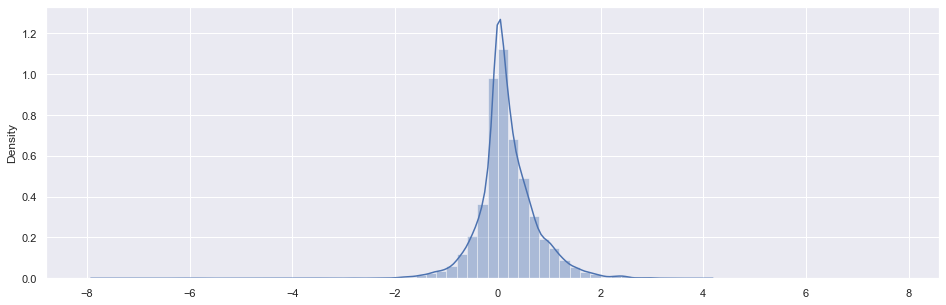

In [110]:
#观察租赁额密度分布
fig = plt.figure()
fig.set_size_inches(16,5)

# 绘制直方图和最大似然高斯分布拟合图
sns.distplot(senti_scores, bins=np.arange(-8,8,0.2), )

In [114]:
def interval_statistics(data, intervals):
    if len(data) == 0:
        return
    for num in data:
        for interval in intervals:
            lr = tuple(interval.split('~'))
            left, right = float(lr[0]), float(lr[1])
            if left <= num <= right:
                intervals[interval] += 1
    for key, value in intervals.items():
        print("%10s" % key, end='')  # 借助 end=''可以不换行
        print("%10s" % value, end='')  # "%10s" 右对齐
        print('%16s' % '{:.3%}'.format(value * 1.0 / len(data)))
    
    score_distribution_df = pd.DataFrame()
    ranges = []
    times = []
    ratio = []
    
    for key, value in intervals.items():
        ranges.append(key)
        times.append(value)
        ratio.append(value * 1.0 / len(data))
        
    score_distribution_df['ranges'] = ranges
    score_distribution_df['times'] = times
    score_distribution_df['ratio'] = ratio
    
    score_distribution_df.to_csv('./senti_scores/score_distribution.csv', index=False)
        
    


In [116]:
start = -8 # 区间左端点
number_of_interval = 32  # 区间个数
length = 0.5  # 区间长度
intervals = {'{}~{}'.format(float(length*x+start), float(length*(x+1)+start)): 0 for x in range(number_of_interval)}  # 生成区间
interval_statistics(senti_scores, intervals)

 -8.0~-7.5         1          0.009%
 -7.5~-7.0         1          0.009%
 -7.0~-6.5         1          0.009%
 -6.5~-6.0         1          0.009%
 -6.0~-5.5         1          0.009%
 -5.5~-5.0         0          0.000%
 -5.0~-4.5         0          0.000%
 -4.5~-4.0         0          0.000%
 -4.0~-3.5         1          0.009%
 -3.5~-3.0         2          0.017%
 -3.0~-2.5         3          0.026%
 -2.5~-2.0         6          0.051%
 -2.0~-1.5        44          0.375%
 -1.5~-1.0       168          1.431%
 -1.0~-0.5       641          5.460%
  -0.5~0.0      3431         29.225%
   0.0~0.5      5442         46.354%
   0.5~1.0      1688         14.378%
   1.0~1.5       627          5.341%
   1.5~2.0       188          1.601%
   2.0~2.5        59          0.503%
   2.5~3.0        13          0.111%
   3.0~3.5         4          0.034%
   3.5~4.0         1          0.009%
   4.0~4.5         0          0.000%
   4.5~5.0         0          0.000%
   5.0~5.5         0          0.000%
 

## 分析结果

拥有正向情感的推文约占了64%，拥有负向情感的推文只约占了36%，可以看出还是有较多的人对covid vaccine有较积极的态度的
接近60%推文的情感得分落在了(0,1)之间